In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import difflib
import json
from tqdm import tqdm

from transformers import AutoModel, AutoTokenizer

import context
from cont_gen.utils import load_json, load_jsonl, save_jsonl

In [2]:
# Check new para_merge data
merge_data = load_jsonl('../../data/cuad_clean/CUADv1_paras_merge_new.jsonl')
print(len(merge_data))
# Check the offset
for cont in merge_data:
    for para in cont['paras']:
        p_text = para['text']
        for qa in para['qas']:
            for ans in qa['answers']:
                a_t = ans['text']
                p_span = p_text[ans['start_pos']: ans['end_pos'] + 1]
                assert a_t == p_span

510


## Paragraph token number

In [5]:
tk_t5 = AutoTokenizer.from_pretrained('google/flan-t5-base')
tk_llama2 = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf', cache_dir = '/next_share/hf_cache/hub')
tk_llama3 = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3-8B', cache_dir = '/next_share/hf_cache/hub')
tk_mistral = AutoTokenizer.from_pretrained('mistralai/Mixtral-8x7B-v0.1', cache_dir = '/next_share/hf_cache/hub')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
def get_enc_len(text, tokenizer):
    return len(tokenizer.tokenize(text))
print(get_enc_len('Hello world!', tk_t5))

3


In [7]:
all_para_text = [para['text'] for cont in merge_data for para in cont['paras']]
all_para_len_t5 = [get_enc_len(t, tk_t5) for t in tqdm(all_para_text)]

100%|██████████| 31301/31301 [00:09<00:00, 3241.32it/s]


In [8]:
all_para_len_llama2 = [get_enc_len(t, tk_llama2) for t in tqdm(all_para_text)]

100%|██████████| 31301/31301 [00:11<00:00, 2671.67it/s]


In [9]:
all_para_len_llama3 = [get_enc_len(t, tk_llama3) for t in tqdm(all_para_text)]

100%|██████████| 31301/31301 [00:09<00:00, 3345.19it/s]


In [10]:
all_para_len_mistral = [get_enc_len(t, tk_mistral) for t in tqdm(all_para_text)]

100%|██████████| 31301/31301 [00:11<00:00, 2680.40it/s]


In [30]:
def show_length_stat(x, figsize = (6,1.5)):
    """
    Print statistics of a list of int.
    """
    qunt_95 = np.quantile(x, 0.95)
    print(f'mean: {np.mean(x)}, max: {np.max(x)}, 95%: {qunt_95}')
    plt.figure(figsize = figsize)
    _ = plt.boxplot(x, vert = False)

mean: 188.23063160921376, max: 2072, 95%: 627.0


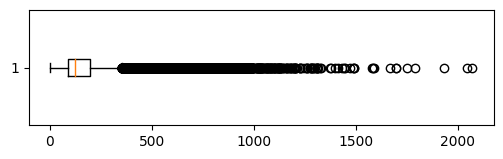

In [31]:
show_length_stat(all_para_len_t5)

mean: 209.1827737132999, max: 3112, 95%: 695.0


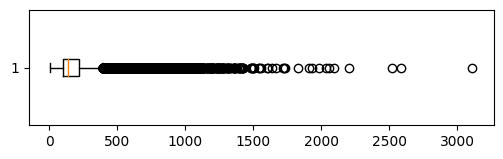

In [32]:
show_length_stat(all_para_len_llama2)

mean: 172.06479026229195, max: 1977, 95%: 577.0


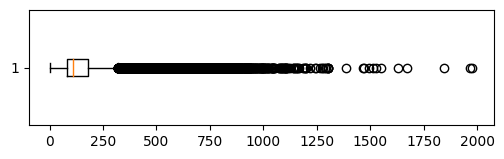

In [33]:
show_length_stat(all_para_len_llama3)

mean: 197.56461454905593, max: 3099, 95%: 656.0


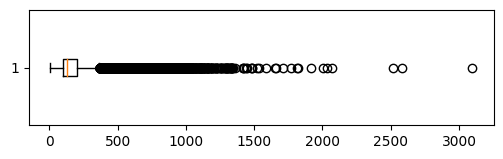

In [34]:
show_length_stat(all_para_len_mistral)

In [23]:
# To check whether decode can recover the exact original text.
# For BPE tokenizers, the original text can be recovered.
exa_text = 'I love panda. \n\n\n. Hello 111111 测试'
def back_trans(tokenizer, text):
    return tokenizer.decode(tokenizer.encode(text, add_special_tokens=False))
print(f't5: {repr(back_trans(tk_t5, exa_text))}')
print(f'llama2: {repr(back_trans(tk_llama2, exa_text))}')
print(f'mistral: {repr(back_trans(tk_mistral, exa_text))}')
print(f'llama3: {repr(back_trans(tk_llama3, exa_text))}')

t5: 'I love panda.. Hello 111111 <unk>'
llama2: 'I love panda. \n\n\n. Hello 111111 测试'
mistral: 'I love panda. \n\n\n. Hello 111111 测试'
llama3: 'I love panda. \n\n\n. Hello 111111 测试'


In [24]:
# The influence of truncation of BPE models.
# If the bytes of one token is truncated, the token becomes a special character
dec_str = tk_llama3.decode(tk_llama3.encode(exa_text, add_special_tokens=False)[:-1])
print(dec_str[-5:])
print(ord(dec_str[-1]))

111 �
65533


### Prompt data

The paragraph is first truncated by LLama3 tokenizer.

In [3]:
os.chdir('/storage_fast/rhshui/workspace/contract_review')

In [5]:
test_data_id = load_jsonl('./data/ood_split/seed42_tr29/pmt_01_yes_no/test_data_id.jsonl')
test_data_ood = load_jsonl('./data/ood_split/seed42_tr29/pmt_01_yes_no/test_data_ood.jsonl')

test_id_df = pd.DataFrame(test_data_id)
test_ood_df = pd.DataFrame(test_data_ood)

In [7]:
# rename small to type
for d in test_data_id:
    d['type'] = d.pop('small')
for d in test_data_ood:
    d['type'] = d.pop('small')

In [8]:
test_data_id[0].keys()

dict_keys(['title', 'para_idx', 'q_id', 'source', 'target', 'type'])

In [ ]:
save_jsonl(test_data_id, './data/ood_split/seed42_tr29/pmt_01_yes_no/test_data_id.jsonl')
save_jsonl(test_data_ood, './data/ood_split/seed42_tr29/pmt_01_yes_no/test_data_ood.jsonl')

In [27]:
print(test_id_df['type'].value_counts())
print(test_ood_df['type'].value_counts())

type
0    111186
2     24062
3     13630
1      1226
Name: count, dtype: int64
type
0    51024
3     5640
2     4882
1      566
Name: count, dtype: int64


In [28]:
src_len_t5 = [get_enc_len(t['source'], tk_t5) for t in tqdm(test_data_ood)]

100%|██████████| 62112/62112 [00:29<00:00, 2077.44it/s]


mean: 266.1870814013395, max: 1182, 95%: 620.0


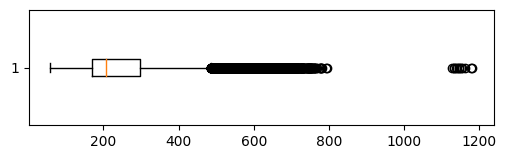

In [35]:
show_length_stat(src_len_t5)

100%|██████████| 62112/62112 [00:29<00:00, 2127.26it/s]


mean: 233.63800875837197, max: 604, 95%: 564.0


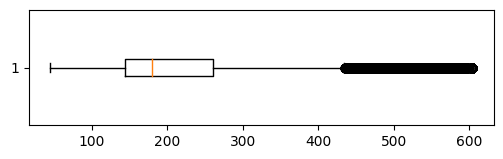

In [36]:
src_len_llama3 = [get_enc_len(t['source'], tk_llama3) for t in tqdm(test_data_ood)]
show_length_stat(src_len_llama3)

In [37]:
part = [d for d, lg in zip(test_data_ood, src_len_t5) if lg > 1000]

In [39]:
part_df = pd.DataFrame(part)

In [41]:
part_df[['title', 'para_idx']].value_counts()

title                                                                            para_idx
PaperexchangeComInc_20000322_S-1A_EX-10.4_5202103_EX-10.4_Co-Branding Agreement  140         12
Name: count, dtype: int64

In [43]:
text = part_df['source'].iloc[0]

In [44]:
print(text)

You are a helpful assistant. Review the contract clauses and answer questions. Output the mentioned clauses if exist; otherwise output "No".

###Clauses:
Source: PAPEREXCHANGE COM INC, S-1/A, 3/22/2000
 such as model number or size to the name. - -------------------------------------------------------------------------------- Category* This field requires a number not word. See the enclosed list. If you do not find a category that fits your product, please contact us. We can add categories. - -------------------------------------------------------------------------------- Mfg/Brand Manufacturer or brand name - -------------------------------------------------------------------------------- Model # Model number - -------------------------------------------------------------------------------- Original Item If known, this can be an incentive to buyers who then see price your lower price. - -------------------------------------------------------------------------------- Height Include fee

In [48]:
print(tk_t5.tokenize(text))

['▁You', '▁are', '▁', 'a', '▁helpful', '▁assistant', '.', '▁Review', '▁the', '▁contract', '▁clause', 's', '▁and', '▁answer', '▁questions', '.', '▁Out', 'put', '▁the', '▁mentioned', '▁clause', 's', '▁', 'if', '▁exist', ';', '▁otherwise', '▁output', '▁"', 'No', '".', '▁#', '##', 'C', 'la', 'use', 's', ':', '▁Source', ':', '▁PA', 'PER', 'E', 'X', 'CHAN', 'GE', '▁', 'COM', '▁INC', ',', '▁S', '-', '1/', 'A', ',', '▁', '3/', '22', '/', '2000', '▁such', '▁as', '▁model', '▁number', '▁or', '▁size', '▁to', '▁the', '▁name', '.', '▁', '-', '▁--', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '---', '▁Category', '*', '▁This', '▁field', '▁requires', '▁', 'a', '▁number', '▁not', '▁word', '.', '▁See', '▁the', '▁enclosed', '▁list', '.', '▁If', '▁you', '▁do', '▁not', '▁find', '▁', 'a', '▁category', '▁that', '▁fits', '▁your', '▁product', ',', '▁please', '▁contact', '▁us', '.', 

In [49]:
print(tk_llama3.tokenize(text))

['You', 'Ġare', 'Ġa', 'Ġhelpful', 'Ġassistant', '.', 'ĠReview', 'Ġthe', 'Ġcontract', 'Ġclauses', 'Ġand', 'Ġanswer', 'Ġquestions', '.', 'ĠOutput', 'Ġthe', 'Ġmentioned', 'Ġclauses', 'Ġif', 'Ġexist', ';', 'Ġotherwise', 'Ġoutput', 'Ġ"', 'No', '".ĊĊ', '###', 'Cla', 'uses', ':Ċ', 'Source', ':', 'ĠP', 'APER', 'EX', 'CHANGE', 'ĠCOM', 'ĠINC', ',', 'ĠS', '-', '1', '/A', ',', 'Ġ', '3', '/', '22', '/', '200', '0', 'Ċ', 'Ġsuch', 'Ġas', 'Ġmodel', 'Ġnumber', 'Ġor', 'Ġsize', 'Ġto', 'Ġthe', 'Ġname', '.', 'Ġ-', 'Ġ--------------------------------------------------------------------------------', 'ĠCategory', '*', 'ĠThis', 'Ġfield', 'Ġrequires', 'Ġa', 'Ġnumber', 'Ġnot', 'Ġword', '.', 'ĠSee', 'Ġthe', 'Ġenclosed', 'Ġlist', '.', 'ĠIf', 'Ġyou', 'Ġdo', 'Ġnot', 'Ġfind', 'Ġa', 'Ġcategory', 'Ġthat', 'Ġfits', 'Ġyour', 'Ġproduct', ',', 'Ġplease', 'Ġcontact', 'Ġus', '.', 'ĠWe', 'Ġcan', 'Ġadd', 'Ġcategories', '.', 'Ġ-', 'Ġ--------------------------------------------------------------------------------', 'ĠM', 'fg', '